# Analysis and Figure Generation for 'Using k-means to sort spectra: electronic order mapping from scanning tunneling spectroscopy measurements'
Created by V. King

Last updated Aug 5, 2024. <br>
Paper to be uploaded to arxiv shortly.

In [17]:
import math
import time
import random
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatcheso
import numpy as np
from numpy import linalg
import scipy.io as sio
from scipy import optimize
from sklearn.cluster import KMeans
from sklearn import metrics
from matplotlib.ticker import FormatStrFormatter
import matplotlib.font_manager as font_manager
from tqdm import tqdm
import pandas as pd
plt.rcParams['savefig.dpi'] = 600
%matplotlib inline

### Load data:
Numerically differentiated $\partial I/\partial V$ data is contained inside the dIdV_data folder in the form of Matlab matrices.

In [20]:
def MATLAB_matrix_to_array(fileName):
    """
    Converts a Matlab '.mat' file into a numpy array.
    Assumes the name of the '.mat' file is the same as the name of the variable

    Parameters
    ----------
    fileName : str
        String containing the file name.

    Returns
    -------
    array
        a numpy array version of the inputted matlab matrix
    """
    
    pathAndFileName = os.getcwd()+'/dIdV_data/'+fileName
    matrix = sio.loadmat(pathAndFileName, appendmat=True)
    array = matrix[fileName]
    print("Shape of array: ",np.shape(array))
    return array


data_5 = MATLAB_matrix_to_array('dIdV_Rh5_4K')
data_18_4K = MATLAB_matrix_to_array('dIdV_Rh18_4K')
data_18_77K = MATLAB_matrix_to_array('dIdV_Rh18_77K')

Shape of array:  (275, 275, 81)
Shape of array:  (275, 275, 81)
Shape of array:  (60, 60, 201)


## General purpose functions:

In [32]:
def flatten(data):
    """
    Flattens array by reducing the spatial dimension. 
    (x,y,energy) -> (x*y, energy)
    or
    (x,y) -> (x*y)
        
    Parameters
    ----------
    data : array_like
        3D array in the shape (x,y,energy), or,
        2D array in the shape (x,y)

    Returns
    -------
    flat_data : array
        2D array in the shape (x*y, energy), or,
        1D array in the shape (x*y)
    """
    if np.ndim(data)== 3:
        flat_data = np.reshape(data, (np.shape(data)[0]*np.shape(data)[1], np.shape(data)[2]))
    elif np.ndim(data)== 2:
        flat_data = np.reshape(data, (np.shape(data)[0]*np.shape(data)[1]))
    else:
        print("Invalid dimensionality of data. Options are 2D or 3D.")
    return flat_data


def fold(flat_data, other_data):
    """
    Unflattens array in the spatial dimension. 
    (x*y,energy) -> (x,y, energy)
    or
    (x*y) -> (x,y)
        
    Parameters
    ----------
    flat_data : array
        2D array in the shape (x*y,energy), or,
        1D array in the shape (x*y)
    other_data : array
        Other dataset with the spatial dimensions desired

    Returns
    -------
    data : array
        3D array in the shape (x, y, energy), or,
        2D array in the shape (x, y)
    """
    if np.ndim(flat_data)== 2:
        data = np.reshape(flat_data, (np.shape(other_data)[0],np.shape(other_data)[1], np.shape(other_data)[2]))
    elif np.ndim(flat_data)== 1:
        data = np.reshape(flat_data, (np.shape(other_data)[0],np.shape(other_data)[1]))
    else:
        print("Invalid dimensionality of data. Options are 1D or 2D.")
    return data

#Define colour dictionary
#Note on colour: '#003C86' is navy for P1
#                '#EF0096' is magenta for M
#                'k' is black for D
#                '#00DCB5'is teal for P2
colour_dict = {'P1':'#003C86', 'P2':'#00DCB5', 'M':'#EF0096','D':'#000000', 'all':'#000000'}

#Define measurement constants dictionary
Rh5_4K_dict = {'startV':-0.8, 'endV':0.8}
Rh18_4K_dict = {'startV':-1.0, 'endV':1.0}
Rh18_77K_dict = {'startV':-1.0, 'endV':1.0}

#Define bias values
def bias(minV, maxV, data):
    """
    Defines array of bias voltage values 
        
    Parameters
    ----------
    minV : float
        value of the first voltage value.
    maxV : float
        value of the last voltage value
    data : array
        data with the energy dimension desired

    Returns
    -------
    V : array
        1D array that contains values from minV to maxV of the length of the energy dimension of data
    """
    V = np.linspace(minV, maxV, num=len(data[0][0]))
    return V

def pos_selector(x,y,data):
    """
    Return array of indices for 2D equivalent of position (x,y) and surrounding pixels
        
    Parameters
    ----------
    x : int
        x position in pixels
    y : int
        y position in pixels
    data : array
        data that the position corresponds to. At least 2 dimensions corresponding to space

    Returns
    -------
    array
        array of position indices for (x,y) and surrounding pixels for a flattened version of data
    """
    #
    x_length = len(data)
    
    pos00 = x + y*x_length
    pos01 = x + (y+1)*x_length
    pos0_1 = x + (y-1)*x_length
    pos10 = (x+1) + y*x_length
    pos_10 = (x-1) + y*x_length
    
    return [pos00, pos01, pos0_1, pos10, pos_10]

## k-means related functions

In [33]:
def my_kmeans(dataset, n_clusters):
    """
        Runs k-means clustering algorithm on hyperspectral data
        Uses 'k-means++' centroid initialization for quicker optimization and is seeded for reproducibility
        See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
        
        Parameters
        ----------
        dataset : array_like
            data in the shape (n_samples, n_features), ie: (75625, 81)
        n_clusters : int
            number of clusters for k-means to generate

        Returns
        -------
        labels : array
            array of cluster labels for the data
        centroids : array
            array of cluster centroids
        score : float
            value of Calinski-Harabasz indices for the k-means solution. Equivalent to BCSS / WCSS
            See https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index
    """
    data = flatten(dataset)
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=100, max_iter=100, random_state=0).fit(data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    score=0
    if n_clusters !=1:
        score = metrics.calinski_harabasz_score(data, labels)
        print('WCSS / BCSS = {:0.6e}'.format(score))
    print('k-means complete')
    return labels, centroids, score


def save_kmeans(fileName, labels, centroids, data):
    """
        Write and save cluster assignments to a file
        
        Parameters
        ----------
        fileName : str
            String of the base file name to save the results as.
        labels : array
            array of cluster labels
        centroids : array
            array of k-means centroids
        data : array
            data that the k-means results were generated from
    """
    img_labels = fold(labels, data)
    np.savetxt(fileName+"_labels.csv", img_labels, delimiter=',')
    np.savetxt(fileName+"_centroids.csv", centroids, delimiter=',')


def import_kmeans(fileName):
    """
        Import previously calculated kMeans labels and centroids
        
        Parameters
        ----------
        fileName : str
            String of the base file name the results were saved as.
            
        Returns
        -------
        labels : array
            array of previously calculated cluster labels
        centroids : array
            array of previously calculated cluster centroids
    """
    labels = pd.read_csv(fileName+"_labels.csv", sep = ",", header = None)
    centroids = pd.read_csv(fileName+"_centroids.csv", sep = ",", header = None)
    return labels.values, centroids.values

In [111]:
#Compute kmeans on all 3 data sets
labels_5, centroids_5, score_5 = my_kmeans(data_5, 4) #choosing 4 clusters
labels_18, centroids_18, score_18 = my_kmeans(data_18_4K, 2) #choosing 2 clusters
labels_18_77, centroids_18_77, score_18_77 = my_kmeans(data_18_77K, 2) #choosing 2 clusters

save_kmeans("Rh5_4K_4cluster", labels_5, centroids_5, data_5)
save_kmeans("Rh18_4K_2cluster", labels_18, centroids_18, data_18_4K)
save_kmeans("Rh18_77K_2cluster", labels_18_77, centroids_18_77, data_18_77K)

BCSS / WCSS = 2.467402e+04
k-means complete
BCSS / WCSS = 4.929720e+04
k-means complete
BCSS / WCSS = 2.178029e+03
k-means complete


In [7]:
#Load k-means results
labels_5, centroids_5 = import_kmeans("Rh5_4K_4cluster")
labels_18, centroids_18 = import_kmeans("Rh18_4K_2cluster")
labels_18_77, centroids_18_77 = import_kmeans("Rh18_77K_2cluster")

In [34]:
#Define label identities
Rh5_4K_dict['M'] = 0
Rh5_4K_dict['P1'] = 3
Rh5_4K_dict['P2'] = 2
Rh5_4K_dict['D'] = 1

Rh18_4K_dict['P1'] = 1
Rh18_4K_dict['P2'] = 0

Rh18_77K_dict['P1'] = 0
Rh18_77K_dict['P2'] = 1

## Figure 1.c)

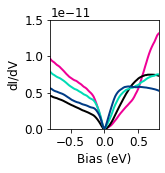

In [21]:
energy = bias(Rh5_4K_dict['startV'], Rh5_4K_dict['endV'], data_5)
    
#Plotting
plt.rcParams['figure.figsize']=(2,2)
fig,(ax1) = plt.subplots()
fig.subplots_adjust(hspace=0.3)
    
ax1.plot(energy,centroids_5[Rh5_4K_dict['M']], marker='',linestyle='-', lw=2, color=colour_dict['M'])
ax1.plot(energy,centroids_5[Rh5_4K_dict['D']], marker='',linestyle='-', lw=2, color=colour_dict['D'])
ax1.plot(energy,centroids_5[Rh5_4K_dict['P2']], marker='',linestyle='-', lw=2, color=colour_dict['P2'])
ax1.plot(energy,centroids_5[Rh5_4K_dict['P1']], marker='',linestyle='-', lw=2, color=colour_dict['P1'])

ax1.set_ylabel("dI/dV")
ax1.set_xlabel("Bias (V)")
ax1.yaxis.set_ticks(np.arange(0.0, 1.51E-11, 0.5E-11))
ax1.set_ylim(0.0, 1.50E-11)
ax1.xaxis.set_ticks(np.arange(-0.5, 0.51, 0.5))
ax1.set_xlim([Rh5_4K_dict['startV'] , Rh5_4K_dict['endV']])
ax1.set_aspect((1.07)*1e11)

#plt.savefig('Plots/Fig1c.svg')    
plt.show()

## Figure 1.d )

<IPython.core.display.Javascript object>


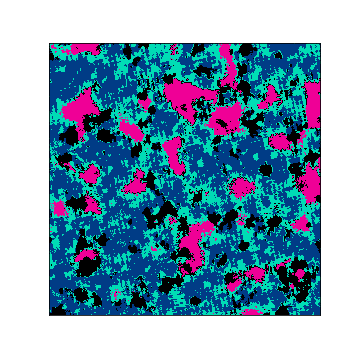

In [70]:
plt.rcParams['figure.figsize']=(5,5)
fig,(ax2) = plt.subplots()
cmap = colors.ListedColormap([colour_dict['M'], colour_dict['D'], colour_dict['P2'], colour_dict['P1']])
ax2.imshow(labels_5, cmap=cmap)
ax2.set_xticks([]); ax2.set_yticks([])
    
#plt.savefig('Plots/Fig1d.svg')
plt.show()

## Supplemental Figure 1 - Demonstration of how k-means works

In [22]:
#Cartoon demonstration of k-means with 'blob' data.
#Based on this demo: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html
#and this demo: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#visualize-the-results-on-pca-reduced-data
from sklearn.datasets import make_blobs

#Cartoon dataset:
cartoon_data, identity = make_blobs(n_samples=800, n_features=2, centers=3, cluster_std=0.8, random_state=0)

### Supplemental Figure 1.b)

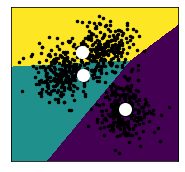

In [24]:
#k-means evaluation, iteration 1:
kmeans = KMeans(n_clusters=3, init='random', n_init=1, max_iter=1,random_state=1231).fit(cartoon_data)
cartoon_labels = kmeans.labels_
cartoon_centroids = kmeans.cluster_centers_

#Voronoi diagram:
step_size = 0.01  # step size of the mesh [x_min, x_max]*[y_min, y_max].
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = cartoon_data[:, 0].min() - 0.5, cartoon_data[:, 0].max() + 0.5
y_min, y_max = cartoon_data[:, 1].min() - 0.5, cartoon_data[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#Plotting
plt.figure(1)
plt.rcParams['figure.figsize']=(3,3)
plt.imshow(Z,interpolation="nearest",extent=(xx.min(),xx.max(),yy.min(),yy.max()),aspect="auto", origin="lower")
plt.plot(cartoon_data[:, 0], cartoon_data[:, 1], "k.", markersize=5)
plt.scatter(cartoon_centroids[:, 0], cartoon_centroids[:, 1], s=100, linewidths=3, color="w", zorder=10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(()); plt.yticks(())
plt.gca().set_aspect('equal')
#plt.savefig('Plots/SupFig1a.svg')
plt.show()

### Supplemental Figure 1.b), panel 1

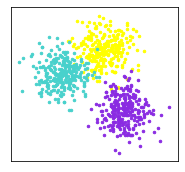

In [25]:
#Making a 'truth' panel for the toy dataset
group_0 = []
group_1 = []
group_2 =[]
for index, ID in enumerate(identity):
    if ID == 0:
        group_0.append(cartoon_data[index])
    if ID == 1:
        group_1.append(cartoon_data[index])
    if ID == 2:
        group_2.append(cartoon_data[index])
group_0 = np.asarray(group_0)
group_1 = np.asarray(group_1)
group_2 = np.asarray(group_2)
        
#Plotting
plt.rcParams['figure.figsize']=(3,3)
fig,(ax1) = plt.subplots(1,1)

ax1.plot(group_0[:,0], group_0[:,1], "yellow", marker='.', markersize=5, linestyle='')
ax1.plot(group_1[:,0], group_1[:,1], "blueviolet", marker='.', markersize=5, linestyle='')
ax1.plot(group_2[:,0], group_2[:,1], "mediumturquoise", marker='.', markersize=5, linestyle='')

ax1.set_xticks([]); ax1.set_yticks([])
ax1.set_aspect(1)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

#plt.savefig('Plots/SupFig1a_truth.svg')
plt.show()

### Supplemental Figure 1.b), panel 2

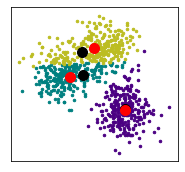

In [267]:
#cartoon of centroid calculation for next iteration
#Want to make 3 subplots, each containing only the points belonging to one cluster, 
#then I want to plot the next centroid over top

cluster0 = []
cluster1 = []
cluster2 = []
for i,label in enumerate(cartoon_labels):
    if label == 0:
        cluster0.append(cartoon_data[i])
    elif label == 1:
        cluster1.append(cartoon_data[i])
    else:
        cluster2.append(cartoon_data[i])
        
cluster0 = np.array(cluster0)
cluster1 = np.array(cluster1)
cluster2 = np.array(cluster2)

#Next iteration centroids:
next_centroid0 = np.average(cluster0,0)
next_centroid1 = np.average(cluster1,0)
next_centroid2 = np.average(cluster2,0)

        
#Plotting
plt.rcParams['figure.figsize']=(3,3)
fig,(ax1) = plt.subplots(1,1)

ax1.plot(cluster0[:,0], cluster0[:,1], "indigo", marker='.', markersize=5, linestyle='')
ax1.scatter(cartoon_centroids[0, 0], cartoon_centroids[0, 1], s=100, linewidths=1, color="k", zorder=10)
ax1.scatter(next_centroid0[0], next_centroid0[1], s=100, linewidths=1, color="r", zorder=10)

ax1.plot(cluster1[:,0], cluster1[:,1], "teal", marker='.', markersize=5, linestyle='')
ax1.scatter(cartoon_centroids[1, 0], cartoon_centroids[1, 1], s=100, linewidths=1, color="k", zorder=10)
ax1.scatter(next_centroid1[0], next_centroid1[1], s=100, linewidths=1, color="r", zorder=10)

ax1.plot(cluster2[:,0], cluster2[:,1], "tab:olive", marker='.', markersize=5, linestyle='')
ax1.scatter(cartoon_centroids[2, 0], cartoon_centroids[2, 1], s=100, linewidths=1, color="k", zorder=10)
ax1.scatter(next_centroid2[0], next_centroid2[1], s=100, linewidths=1, color="r", zorder=10)

ax1.set_xticks([]); ax1.set_yticks([])
ax1.set_aspect(1)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

#plt.savefig('Plots/SupFig1b_alternative.svg')
plt.show()

### Supplemental Figure 1.b), panel 3

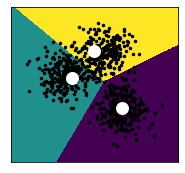

In [268]:
#k-means evaluation, iteration 2:
kmeans = KMeans(n_clusters=3, init='random', n_init=1, max_iter=2,random_state=1231).fit(cartoon_data)
cartoon_labels = kmeans.labels_
cartoon_centroids = kmeans.cluster_centers_

#Voronoi diagram:
step_size = 0.01  # step size of the mesh [x_min, x_max]*[y_min, y_max].
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = cartoon_data[:, 0].min() - 1, cartoon_data[:, 0].max() + 1
y_min, y_max = cartoon_data[:, 1].min() - 1, cartoon_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#Plotting
plt.figure(1)
plt.rcParams['figure.figsize']=(3,3)
plt.imshow(Z,interpolation="nearest",extent=(xx.min(),xx.max(),yy.min(),yy.max()),aspect="auto", origin="lower")
plt.plot(cartoon_data[:, 0], cartoon_data[:, 1], "k.", markersize=5)
plt.scatter(cartoon_centroids[:, 0], cartoon_centroids[:, 1], s=100, linewidths=3, color="w", zorder=10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(()); plt.yticks(())
plt.gca().set_aspect('equal')
#plt.savefig('Plots/SupFig1c.svg')
plt.show()

## Looking at sample spectra from the data set

In [35]:
def spectra_of_interest(data, labels, cluster):
    """
    Pick out spectra belonging to different clusters

    Parameters
    ----------
    data : array
        data array in shape (x,y,energy)
    labels : array
        k-means calculated labels in shape (x,y)
    cluster : int
        cluster of interest using value from labels. For all data points, set cluster = 10

    Returns
    -------
    spectra : array
        array containing all spectra belonging to the cluster of interest
    """
    
    #First, make 2D version of data array, ie:(275,275,81)-->(75625, 81)
    data_2D = flatten(data)
    labels_1D = flatten(labels)
    #Next, pick out the spectra that fall under the specified cluster and add them to a list
    spectra = []
    if cluster==10:
        for index, label in enumerate(labels_1D):
            spectra.append(data_2D[index])
    else:
        for index, label in enumerate(labels_1D):
            if label==cluster: 
                spectra.append(data_2D[index])
        
    return spectra

#divide up the spectra into its clusters:
M_spectra = spectra_of_interest(data_5, labels_5, Rh5_4K_dict['M'])
P1_spectra = spectra_of_interest(data_5, labels_5, Rh5_4K_dict['P1'])
D_spectra = spectra_of_interest(data_5, labels_5, Rh5_4K_dict['D'])
P2_spectra = spectra_of_interest(data_5, labels_5, Rh5_4K_dict['P2'])
All_spectra = spectra_of_interest(data_5, labels_5, 10)
print("There are ",np.shape(M_spectra)[0]," Mott spectra (magenta).")
print("There are ",np.shape(D_spectra)[0]," defect spectra (black).")
print("There are ",np.shape(P1_spectra)[0]," P1 spectra (dark blue).")
print("There are ",np.shape(P2_spectra)[0]," P2 spectra (teal).")
print("There are ",np.shape(All_spectra)[0]," All spectra (black).")

There are  9758  Mott spectra (magenta).
There are  12477  defect spectra (black).
There are  28818  P1 spectra (dark blue).
There are  24572  P2 spectra (teal).
There are  75625  All spectra (black).


In [39]:
#Want to choose and average over some example spectra
P1_position = pos_selector(240,5,data_5)
P2_position = pos_selector(225,112,data_5)
D_position = pos_selector(255,133,data_5)
M_position = pos_selector(130,55,data_5)


def sample_spectrum_of_interest(data, M_pos, D_pos, P1_pos, P2_pos):
    """
    Pick out sample spectra belonging to different clusters at specific points

    Parameters
    ----------
    data : array
        data array in shape (x,y,energy)
    X_pos : array
        1D pixel positions of spectra to average, belonging to the 'X' cluster
    Returns
    -------
    sample_spectra : dict
        dictionary containing array of all sample spectra
    """
    
    data_2D = flatten(data)
    M_spectrum = [np.mean([data_2D[M_pos[j],i] for j in range(len(M_pos))]) for i in range(len(data_2D[0]))]
    D_spectrum = [np.mean([data_2D[D_pos[j],i] for j in range(len(D_pos))]) for i in range(len(data_2D[0]))]
    P1_spectrum = [np.mean([data_2D[P1_pos[j],i] for j in range(len(P1_pos))]) for i in range(len(data_2D[0]))]
    P2_spectrum = [np.mean([data_2D[P2_pos[j],i] for j in range(len(P2_pos))]) for i in range(len(data_2D[0]))]
    
    sample_spectra = {'M':M_spectrum, 'D':D_spectrum, 'P1':P1_spectrum, 'P2':P2_spectrum}
    
    return sample_spectra


#divide up the spectra into its clusters:
sample_spectra = sample_spectrum_of_interest(data_5, M_position, D_position, P1_position, P2_position)

## Figure 1.a)

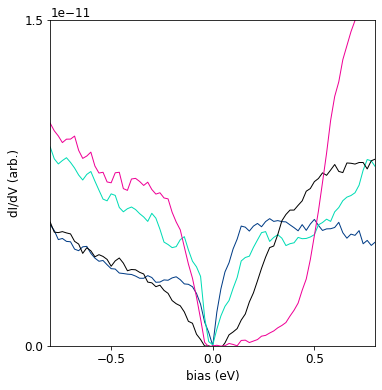

In [40]:
energy = bias(Rh5_4K_dict['startV'], Rh5_4K_dict['endV'], data_5)

#Plotting
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams.update({'font.size': 12})
fig,(ax1) = plt.subplots()

ax1.plot(energy, sample_spectra['P1'], marker='',linestyle='-', lw=1, color=colour_dict['P1'])
ax1.plot(energy, sample_spectra['P2'], marker='',linestyle='-', lw=1, color=colour_dict['P2'])
ax1.plot(energy, sample_spectra['D'], marker='',linestyle='-', lw=1, color=colour_dict['D'])
ax1.plot(energy, sample_spectra['M'], marker='',linestyle='-', lw=1, color=colour_dict['M'])

ax1.set_ylabel("dI/dV (arb.)", fontsize=12)
ax1.set_xlabel("bias (eV)", fontsize=12)
ax1.set_xlim([Rh5_4K_dict['startV'] , Rh5_4K_dict['endV']])
ax1.set_aspect((1.07)*1e11)
ax1.yaxis.set_ticks(np.arange(0.0, 1.51E-11, 1.5E-11))
ax1.set_ylim([0.0E-11,1.5E-11])
ax1.xaxis.set_ticks(np.arange(-0.5, 0.51, 0.5))

#plt.savefig('Plots/Fig1a.svg')
plt.show()

## Supplemental Figure 2.

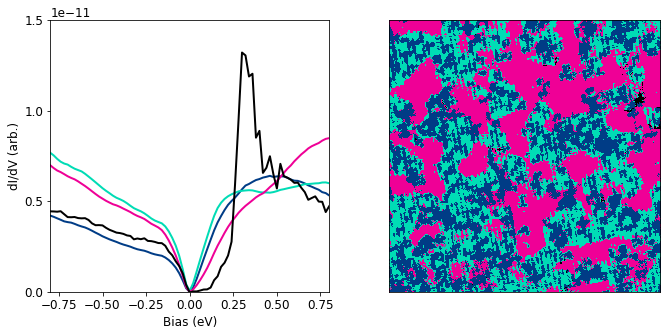

In [91]:
#Only 1 iteration starting at random

#Data needs to be in shape (n_samples, n_features), ie: (75625, 81)
flat_data_5 = flatten(data_5)
kmeans = KMeans(n_clusters=4, init='random', n_init=1, max_iter=1, random_state=0).fit(flat_data)
random_labels = kmeans.labels_
random_centroids = kmeans.cluster_centers_

energy = bias(Rh5_4K_dict['startV'], Rh5_4K_dict['endV'], data_5)
img_labels_random = fold(random_labels, data_5) #Reformating labels for map layout
    
#Plotting
plt.rcParams['figure.figsize']=(11,5)
plt.rcParams.update({'font.size': 12})
fig,(ax1,ax2) = plt.subplots(1,2)
fig.subplots_adjust(hspace=0.3)
    
ax1.plot(energy,random_centroids[0], marker='',linestyle='-', lw=2, color=colour_dict['P1'])
ax1.plot(energy,random_centroids[1], marker='',linestyle='-', lw=2, color=colour_dict['P2'])
ax1.plot(energy,random_centroids[2], marker='',linestyle='-', lw=2, color=colour_dict['M'])
ax1.plot(energy,random_centroids[3], marker='',linestyle='-', lw=2, color=colour_dict['D'])

ax1.set_ylabel("dI/dV (arb.)")
ax1.set_xlabel("Bias (eV)")
ax1.set_xlim([Rh5_4K_dict['startV'], Rh5_4K_dict['endV']])
ax1.yaxis.set_ticks(np.arange(0.0, 1.51E-11, 0.5E-11))
ax1.set_ylim(0.0, 1.50E-11)
    
cmap = colors.ListedColormap([colour_dict['P1'],colour_dict['P2'],colour_dict['M'],colour_dict['D']])
ax2.imshow(img_labels_random, cmap=cmap)
ax2.set_xticks([]); ax2.set_yticks([])
#plt.savefig('Plots/SupFig1d.svg')
plt.show()

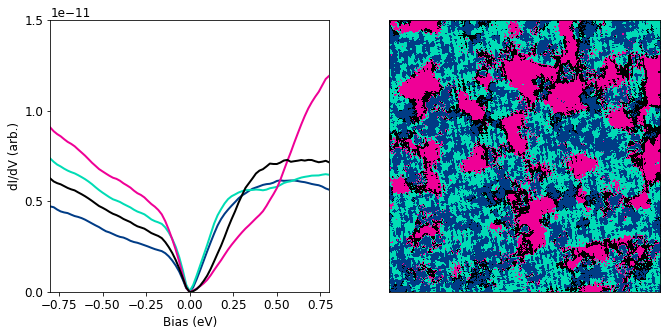

In [94]:
#5 iterations starting at random

#Data needs to be in shape (n_samples, n_features), ie: (75625, 81)
flat_data = flatten(data_5)
kmeans = KMeans(n_clusters=4, init='random', n_init=1, max_iter=5, random_state=0).fit(flat_data)
random_labels = kmeans.labels_
random_centroids = kmeans.cluster_centers_

energy = bias(Rh5_4K_dict['startV'], Rh5_4K_dict['endV'], data_5)
img_labels_random = fold(random_labels, data_5) #Reformating labels for map layout
    
#Plotting
plt.rcParams['figure.figsize']=(11,5)
plt.rcParams.update({'font.size': 12})
fig,(ax1,ax2) = plt.subplots(1,2)
fig.subplots_adjust(hspace=0.3)
    
ax1.plot(energy,random_centroids[0], marker='',linestyle='-', lw=2, color=colour_dict['P1'])
ax1.plot(energy,random_centroids[1], marker='',linestyle='-', lw=2, color=colour_dict['P2'])
ax1.plot(energy,random_centroids[2], marker='',linestyle='-', lw=2, color=colour_dict['M'])
ax1.plot(energy,random_centroids[3], marker='',linestyle='-', lw=2, color=colour_dict['D'])

ax1.set_ylabel("dI/dV (arb.)")
ax1.set_xlabel("Bias (eV)")
ax1.set_xlim([Rh5_4K_dict['startV'], Rh5_4K_dict['endV']])
ax1.yaxis.set_ticks(np.arange(0.0, 1.51E-11, 0.5E-11))
ax1.set_ylim(0.0, 1.50E-11)
    
cmap = colors.ListedColormap([colour_dict['P1'],colour_dict['P2'],colour_dict['M'],colour_dict['D']])
ax2.imshow(img_labels_random, cmap=cmap)
ax2.set_xticks([]); ax2.set_yticks([])
    
#plt.savefig('Plots/SupFig1e.svg')
plt.show()

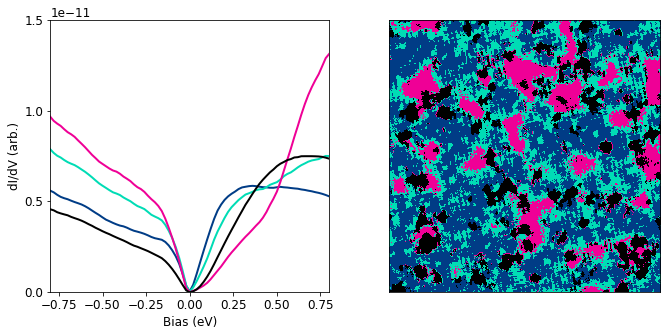

In [165]:
#100 iterations starting at random

#Data needs to be in shape (n_samples, n_features), ie: (75625, 81)
flat_data = flatten(data_5)
kmeans = KMeans(n_clusters=4, init='random', n_init=1, max_iter=100, random_state=0).fit(flat_data)
random_labels = kmeans.labels_
random_centroids = kmeans.cluster_centers_

energy = bias(Rh5_4K_dict['startV'], Rh5_4K_dict['endV'], data_5)
img_labels_random = fold(random_labels, data_5) #Reformating labels for map layout
    
#Plotting
plt.rcParams['figure.figsize']=(11,5)
plt.rcParams.update({'font.size': 12})
fig,(ax1,ax2) = plt.subplots(1,2)
fig.subplots_adjust(hspace=0.3)
    
ax1.plot(energy,random_centroids[0], marker='',linestyle='-', lw=2, color=colour_dict['P1'])
ax1.plot(energy,random_centroids[1], marker='',linestyle='-', lw=2, color=colour_dict['P2'])
ax1.plot(energy,random_centroids[2], marker='',linestyle='-', lw=2, color=colour_dict['M'])
ax1.plot(energy,random_centroids[3], marker='',linestyle='-', lw=2, color=colour_dict['D'])

ax1.set_ylabel("dI/dV (arb.)")
ax1.set_xlabel("Bias (eV)")
ax1.set_xlim([Rh5_4K_dict['startV'], Rh5_4K_dict['endV']])
ax1.yaxis.set_ticks(np.arange(0.0, 1.51E-11, 0.5E-11))
ax1.set_ylim(0.0, 1.50E-11)
    
cmap = colors.ListedColormap([colour_dict['P1'],colour_dict['P2'],colour_dict['M'],colour_dict['D']])
ax2.imshow(img_labels_random, cmap=cmap)
ax2.set_xticks([]); ax2.set_yticks([])
    
#plt.savefig('Plots/SupFig1f.svg')
plt.show()

In [16]:
def kmeans_alternate_methods(dataset, n_clusters, initial_centroids):
    """
    Calculates k-means using manually-defined initial centroids and random initial centroids

    Parameters
    ----------
    dataset : array
        data array in shape (x,y,energy)
    n_clusters : int
        number of clusters for k-means, k
    initial_centroids : array
        array of initial centroids to provide k-means
    Returns
    -------
    labels_example : array
        cluster labels from k-means with manually-defined initial centroids
    centroids_example : array
        centroids from k-means with manually-defined initial centroids
    score_example : float
        WCSS/BCSS from k-means with manually-defined initial centroids
    labels_random : array
        cluster labels from k-means with random initial centroids
    centroids_random : array
        centroids from k-means with random initial centroids
    score_random : float
        WCSS/BCSS from k-means with random initial centroids
    """
    
    #Data needs to be in shape (n_samples, n_features), ie: (75625, 81)
    data = flatten(dataset)
    
    #Trying to input example spectra as initial centroids:
    kmeans_example = KMeans(n_clusters=n_clusters, init=initial_centroids, n_init=1, max_iter=100, random_state=0).fit(data)
    labels_example = kmeans_example.labels_
    centroids_example = kmeans_example.cluster_centers_
    score_example = metrics.calinski_harabasz_score(data, labels_example)
    print('k-means complete. WCSS / BCSS = {:0.6e}'.format(score_example))
    
    #Random choice of centroids
    kmeans_random = KMeans(n_clusters=n_clusters, init='random', n_init=10, max_iter=100, random_state=0).fit(data)
    labels_random = kmeans_random.labels_
    centroids_random = kmeans_random.cluster_centers_
    score_random = metrics.calinski_harabasz_score(data, labels_random)
    print('k-means complete. WCSS / BCSS = {:0.6e}'.format(score_random))
    
    return labels_example, centroids_example, score_example, labels_random, centroids_random, score_random


#My choice of ideal initial centroids:
initial_centroids = np.asarray([M_sample_spectra, P1_sample_spectra, D_sample_spectra, P2_sample_spectra])

#Run the alternate kmeans methods:
labels_example, centroids_example, score_example, labels_random, centroids_random, score_random = kmeans_alternate_methods(data_5, 4, initial_centroids)


k-means complete. BCSS / WCSS = 2.467396e+04
k-means complete. BCSS / WCSS = 2.467399e+04


## Supplemental Figure 3

Percentage mismatch between kmeans++ and intial centroids solutions: 0.74%
Percentage mismatch between kmeans++ and random solutions: 0.24%


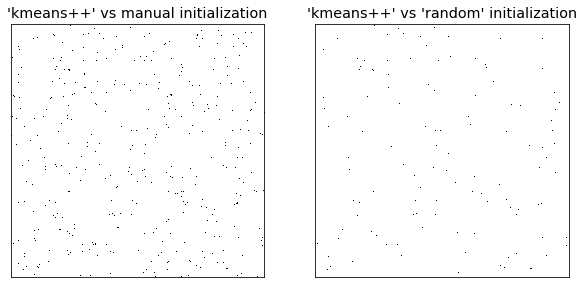

In [45]:
#Mapping the differences in results between 'kmeans++', 'random', or providing initial centroids
labels_kmeans_plus = flatten(labels_5)

kmeans_Plus_labelled = ['M' if i==Rh5_4K_dict['M'] else i for i in labels_kmeans_plus]
kmeans_Plus_labelled = ['P1' if i==Rh5_4K_dict['P1'] else i for i in kmeans_Plus_labelled]
kmeans_Plus_labelled = ['P2' if i==Rh5_4K_dict['P2'] else i for i in kmeans_Plus_labelled]
kmeans_Plus_labelled = ['D' if i==Rh5_4K_dict['D'] else i for i in kmeans_Plus_labelled]

example_labelled = ['M' if i==0 else i for i in labels_example]
example_labelled = ['P1' if i==1 else i for i in example_labelled]
example_labelled = ['P2' if i==3 else i for i in example_labelled]
example_labelled = ['D' if i==2 else i for i in example_labelled]

random_labelled = ['M' if i==1 else i for i in labels_random]
random_labelled = ['P1' if i==2 else i for i in random_labelled]
random_labelled = ['P2' if i==3 else i for i in random_labelled]k
random_labelled = ['D' if i==0 else i for i in random_labelled]

example_mismatch = np.asarray([kmeans_Plus_labelled[i]!=example_labelled[i] for i in range(np.shape(labels_kmeans_plus)[0])])
example_percentage = mismatch.sum()/np.shape(labels_kmeans_plus)[0]
print("Percentage mismatch between kmeans++ and intial centroids solutions: {:0.2%}".format(example_percentage))

random_mismatch = np.asarray([kmeans_Plus_labelled[i]!=random_labelled[i] for i in range(np.shape(labels_kmeans_plus)[0])])
random_percentage = random_mismatch.sum()/np.shape(labels_kmeans_plus)[0]
print("Percentage mismatch between kmeans++ and random solutions: {:0.2%}".format(random_percentage))
                          
fig, (ax1,ax2) = plt.subplots(1,2)
plt.rcParams['figure.figsize']=(10,5)
plt.rcParams.update({'font.size': 12})
cmap = colors.ListedColormap(['w','k'])

img_example_mismatch = fold(example_mismatch,data_5) #Reformating labels for map layout
ax1.imshow(img_example_mismatch, cmap=cmap)
ax1.set_title("'kmeans++' vs manual initialization")
ax1.set_xticks([]); ax1.set_yticks([])

img_random_mismatch = fold(random_mismatch,data_5) #Reformating labels for map layout
ax2.imshow(img_random_mismatch, cmap=cmap)
ax2.set_title("'kmeans++' vs 'random' initialization")
ax2.set_xticks([]); ax2.set_yticks([])
    
#plt.savefig('Plots/SupFig2ab.svg')
plt.show()

## Supplemental Figure 4.c)

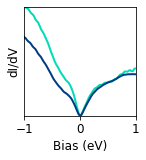

In [39]:
energy = bias(Rh18_4K_dict['startV'], Rh18_4K_dict['endV'], data_18_4K)
    
#Plotting
plt.rcParams['figure.figsize']=(2,2)
fig,(ax1) = plt.subplots()
fig.subplots_adjust(hspace=0.3)
    
ax1.plot(energy,centroids_18[Rh18_4K_dict['P2']], marker='',linestyle='-', lw=2, color=colour_dict['P2'])
ax1.plot(energy,centroids_18[Rh18_4K_dict['P1']], marker='',linestyle='-', lw=2, color=colour_dict['P1'])

ax1.set_ylabel("dI/dV")
ax1.set_xlabel("Bias (eV)")
ax1.set_ylim(0.0, 1.80E-11)
ax1.set_yticks([])
ax1.set_xlim([Rh18_4K_dict['startV'] , Rh18_4K_dict['endV']])


plt.savefig('Plots/Sup_Figure_3c.svg')    
plt.show()

## Supplemental Figure 3.d)

<IPython.core.display.Javascript object>


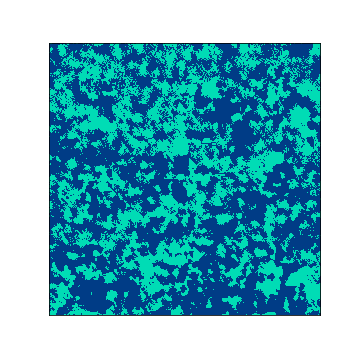

In [103]:
plt.rcParams['figure.figsize']=(5,5)
fig,(ax2) = plt.subplots()
cmap = colors.ListedColormap([colour_dict['P2'], colour_dict['P1']])
ax2.imshow(labels_18, cmap=cmap)
ax2.set_xticks([]); ax2.set_yticks([])
    
#plt.savefig('Plots/Sup_Figure_3d.svg')
plt.show()

In [80]:
def P_sample_spectrum_of_interest(data, P1x, P1y, P2x, P2y):
    """
    Pick out sample spectra belonging to P1 and P2 at specific points, 

    Parameters
    ----------
    data : array
        data array in shape (x,y,energy)
    P1x : int
        x pixel position belonging to P1
    P1y : int
        y pixel position belonging to P1
    P2x : int
        x pixel position belonging to P2
    P2y : int
        y pixel position belonging to P2
    Returns
    -------
    sample_spectra : dict
        dictionary containing array of sample spectra for P1 and P2
    """
    
    data_2D = flatten(data)
    
    P1_pos = pos_selector(P1x, P1y, data)
    P2_pos = pos_selector(P2x, P2y, data)
    
    P1_spectrum = [np.mean([data_2D[P1_pos[j],i] for j in range(len(P1_pos))]) for i in range(len(data_2D[0]))]
    P2_spectrum = [np.mean([data_2D[P2_pos[j],i] for j in range(len(P2_pos))]) for i in range(len(data_2D[0]))]
    
    sample_spectra = {'P1':P1_spectrum, 'P2':P2_spectrum}
    
    return sample_spectra


#divide up the spectra into its clusters:

sample_spectra_18_4K = P_sample_spectrum_of_interest(data_18_4K, 197, 96, 135, 105)

## Supplemental Figure 3.a)

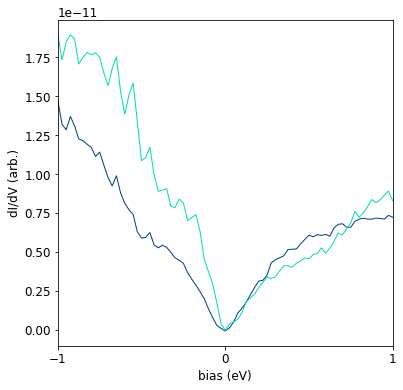

In [88]:
energy = bias(Rh18_4K_dict['startV'], Rh18_4K_dict['endV'], data_18_4K)

#Plotting
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams.update({'font.size': 12})
fig,(ax1) = plt.subplots()

ax1.plot(energy, sample_spectra_18_4K['P1'], marker='',linestyle='-', lw=1, color=colour_dict['P1'])
ax1.plot(energy, sample_spectra_18_4K['P2'], marker='',linestyle='-', lw=1, color=colour_dict['P2'])

ax1.set_ylabel("dI/dV (arb.)", fontsize=12)
ax1.set_xlabel("bias (eV)", fontsize=12)
ax1.set_xlim([Rh18_4K_dict['startV'] , Rh18_4K_dict['endV']])
ax1.xaxis.set_ticks(np.arange(-1.0, 1.01, 1.0))

plt.savefig('Plots/Sup_Figure_3a.svg')
plt.show()

## Supplemental Figure 6.c)

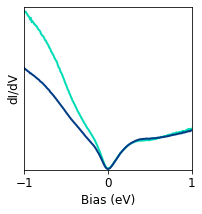

In [98]:
energy = bias(Rh18_77K_dict['startV'], Rh18_77K_dict['endV'], data_18_77K)
    
#Plotting
plt.rcParams['figure.figsize']=(3,3)
fig,(ax1) = plt.subplots()
fig.subplots_adjust(hspace=0.3)

ax1.plot(energy,centroids_18_77[Rh18_77K_dict['P2']], marker='',linestyle='-', lw=2, color=colour_dict['P2'])
ax1.plot(energy,centroids_18_77[Rh18_77K_dict['P1']], marker='',linestyle='-', lw=2, color=colour_dict['P1'])

ax1.set_ylabel("dI/dV")
ax1.set_xlabel("Bias (eV)")
ax1.set_ylim(0.0, 1.70E-11)
ax1.set_yticks([])
ax1.set_xlim([Rh18_77K_dict['startV'] , Rh18_77K_dict['endV']])
ax1.xaxis.set_ticks(np.arange(-1.0, 1.01, 1.0))

#plt.savefig('Plots/Sup_Figure_7c.svg')    
plt.show()

## Supplemental Figure 6.d)

<IPython.core.display.Javascript object>


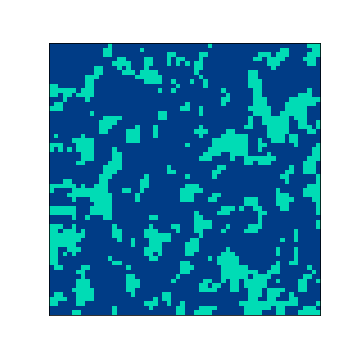

In [104]:
plt.rcParams['figure.figsize']=(5,5)
fig,(ax2) = plt.subplots()
cmap = colors.ListedColormap([colour_dict['P1'], colour_dict['P2']])
ax2.imshow(labels_18_77, cmap=cmap)
ax2.set_xticks([]); ax2.set_yticks([])
    
#plt.savefig('Plots/Sup_Figure_7d.svg')
plt.show()

## Supplemental Figure 6.a)

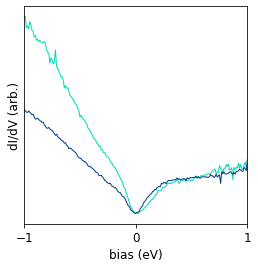

In [111]:
#divide up the spectra into its clusters:

sample_spectra_18_77K = P_sample_spectrum_of_interest(data_18_77K, 17, 11, 40, 21)

energy = bias(Rh18_77K_dict['startV'], Rh18_77K_dict['endV'], data_18_77K)

#Plotting
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams.update({'font.size': 12})
fig,(ax1) = plt.subplots()

ax1.plot(energy, sample_spectra_18_77K['P2'], marker='',linestyle='-', lw=1, color=colour_dict['P2'])
ax1.plot(energy, sample_spectra_18_77K['P1'], marker='',linestyle='-', lw=1, color=colour_dict['P1'])

ax1.set_ylabel("dI/dV (arb.)", fontsize=12)
ax1.set_xlabel("bias (eV)", fontsize=12)
ax1.set_xlim([Rh18_77K_dict['startV'] , Rh18_77K_dict['endV']])
ax1.xaxis.set_ticks(np.arange(-1.0, 1.01, 1.0))
ax1.yaxis.set_ticks([])

plt.savefig('Plots/Sup_Figure_7a.svg')
plt.show()

In [44]:
flat_labels_5 = flatten(labels_5)
centroid_M_indices  = np.reshape(np.where(flat_labels_5==Rh5_4K_dict['M']), -1)
centroid_P1_indices  = np.reshape(np.where(flat_labels_5==Rh5_4K_dict['P1']), -1)
centroid_P2_indices  = np.reshape(np.where(flat_labels_5==Rh5_4K_dict['P2']), -1)
centroid_D_indices  = np.reshape(np.where(flat_labels_5==Rh5_4K_dict['D']), -1)

#Choosing 100 random spectra from cluster to plot:
rng = np.random.default_rng(seed=0)
index_choice_M = rng.choice(centroid_M_indices,100, replace=False)
index_choice_P1 = rng.choice(centroid_P1_indices,100, replace=False)
index_choice_P2 = rng.choice(centroid_P2_indices,100, replace=False)
index_choice_D = rng.choice(centroid_D_indices,100, replace=False)

def sampling_subplot(ax, centroid_index, centroids, index_choice, color, startV, endV, data):
    """
    Plot a sampling of spectra belonging to a given centroid

    Parameters
    ----------
    ax : axis
        figure axis object
    centroid_index : int
        index corresponding to centroid
    centroids : array
        array of k-means calculated centroids
    index_choice : array
        array of indices of point spectra to plot
    color : str
        colour for centroid
    startV : float
        starting voltage value
    endV : float
        final voltage value
    data : array
        array of data in shape (x,y,energy)
    """
    energy = bias(startV, endV, data_5)
    flattened_data = flatten(data)
    
    for i in range(100):
        ax.plot(energy, flattened_data[index_choice[i]], marker='',ls='-', color='gray', alpha=0.3,lw=0.5)
    
    #plot the centroid spectrum
    ax.plot(energy,centroids[centroid_index], marker='',linestyle='-', color=color, lw=2)
    ax.set_xlim([startV, endV])
    ax.set_ylim([-0.1E-11,1.5E-11])
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks(np.arange(-0.5, 0.51, 0.5))
    return

## Figure 2.c) - 2.f)

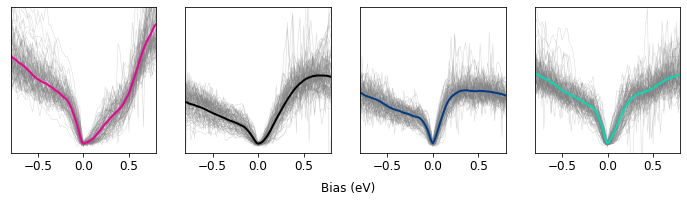

In [45]:
energy = bias(Rh5_4K_dict['startV'], Rh5_4K_dict['endV'], data_5)

#Plotting
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize']=(12,3)
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,sharex=True)

sampling_subplot(ax1, Rh5_4K_dict['M'], centroids_5, index_choice_M, colour_dict['M'], 
                 Rh5_4K_dict['startV'], Rh5_4K_dict['endV'], data_5)
ax1.set_aspect((1.0)*1e11)
sampling_subplot(ax2, Rh5_4K_dict['D'], centroids_5, index_choice_D, colour_dict['D'], 
                 Rh5_4K_dict['startV'], Rh5_4K_dict['endV'], data_5)
ax2.set_aspect((1.0)*1e11)
sampling_subplot(ax3, Rh5_4K_dict['P1'], centroids_5, index_choice_P1, colour_dict['P1'], 
                 Rh5_4K_dict['startV'], Rh5_4K_dict['endV'], data_5)
ax3.set_aspect((1.0)*1e11)
sampling_subplot(ax4, Rh5_4K_dict['P2'], centroids_5, index_choice_P2, colour_dict['P2'], 
                 Rh5_4K_dict['startV'], Rh5_4K_dict['endV'], data_5)
ax4.set_aspect((1.0)*1e11)

# Set Title and x label
fig.text(0.515, 0.00, 'Bias (eV)', ha='center', va='center', fontsize=12)

#plt.savefig('Plots/Figure_2cdef.svg')
plt.show()

## Supplemental Figure 5

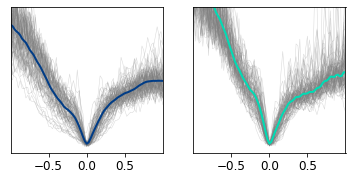

In [46]:
flat_labels_18 = flatten(labels_18)
centroid_P1_indices  = np.reshape(np.where(flat_labels_18==Rh18_4K_dict['P1']), -1)
centroid_P2_indices  = np.reshape(np.where(flat_labels_18==Rh18_4K_dict['P2']), -1)

#Choosing 100 random spectra from cluster to plot:
rng = np.random.default_rng(seed=0)
index_choice_P1 = rng.choice(centroid_P1_indices,100, replace=False)
index_choice_P2 = rng.choice(centroid_P2_indices,100, replace=False)

#Plotting
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize']=(6,3)
fig,(ax1,ax2) = plt.subplots(1,2,sharex=True)

sampling_subplot(ax1, Rh18_4K_dict['P1'], centroids_18, index_choice_P1, colour_dict['P1'], Rh18_4K_dict['startV'], Rh18_4K_dict['endV'], data_18_4K)
ax1.set_aspect((1.2)*1e11)
sampling_subplot(ax2, Rh18_4K_dict['P2'], centroids_18, index_choice_P2, colour_dict['P2'], Rh18_4K_dict['startV'], Rh18_4K_dict['endV'], data_18_4K)
ax2.set_aspect((1.2)*1e11)

plt.savefig('Plots/Sup_Figure_4ab.svg')
plt.show()

## Supplemental Figure 7

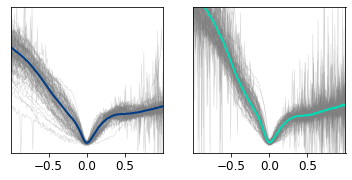

In [19]:
flat_labels_18_77 = flatten(labels_18_77)
centroid_P1_indices  = np.reshape(np.where(flat_labels_18_77==Rh18_77K_dict['P1']), -1)
centroid_P2_indices  = np.reshape(np.where(flat_labels_18_77==Rh18_77K_dict['P2']), -1)

#Choosing 100 random spectra from cluster to plot:
rng = np.random.default_rng(seed=0)
index_choice_P1 = rng.choice(centroid_P1_indices,100, replace=False)
index_choice_P2 = rng.choice(centroid_P2_indices,100, replace=False)

#Plotting
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize']=(6,3)
fig,(ax1,ax2) = plt.subplots(1,2,sharex=True)

sampling_subplot(ax1, Rh18_77K_dict['P1'], centroids_18_77, index_choice_P1, 
                 colour_dict['P1'], Rh18_77K_dict['startV'], Rh18_77K_dict['endV'], data_18_77K)
ax1.set_aspect((1.2)*1e11)
sampling_subplot(ax2, Rh18_77K_dict['P2'], centroids_18_77, index_choice_P2, 
                 colour_dict['P2'], Rh18_77K_dict['startV'], Rh18_77K_dict['endV'], data_18_77K)
ax2.set_aspect((1.2)*1e11)

plt.savefig('Plots/Sup_Figure_8ab.svg')
plt.show()

# Analysis of different number of clusters

In [ ]:
def error_test(data, num_clusters):
    """
    Analysis of inertia (WCSS) and Calinsky-Harabasz scores (WCSS/BCSS)

    Parameters
    ----------
    data : array
        array of data in shape (x,y,energy)
    num_clusters : int
        number of clusters for k-means, k
        
    Returns
    -------
    score_dictionary : dict
        dictionary containing inertia and CH scores for each run of k-means
    """
    inertia = []
    CH_score = []
    for i in range(len(num_clusters)):
        sum_squares = []
        labels, centroids, score = my_kmeans(data, num_clusters[i])
        if num_clusters !=1:
            CH_score.append(score)
        
        #Inertia calculation:
        for j in tqdm(range(num_clusters[i])): #for each cluster,
            spectra = spectra_of_interest(data, labels, j) #the spectra of this cluster
            squares = [(centroids[j]-spectra[k])**2 for k in range(len(spectra))] #vector subtraction
            sum_squares.append(np.sum(squares)) # sum of squares for this cluster
        inertia.append(np.sum(sum_squares))# sum of squares of ALL clusters
    score_dictionary = {'inertia':inertia, 'CH':CH_score}
    return score_dictionary

In [ ]:
Rh5_scores = error_test(data_5, [1,2,3,4,5,6,7,8])

#save to error values to file
dataframe = pd.DataFrame(Rh5_scores)
dataframe.to_csv("Rh5_scores"+ ".csv", index=False)

In [ ]:
Rh18_scores = error_test(data_18_4K, [1,2,3,4,5,6,7,8])

#save to error values to file
dataframe = pd.DataFrame(Rh18_scores)
dataframe.to_csv("Rh18_scores"+ ".csv", index=False)

In [ ]:
Rh18_77_scores = error_test(data_18_77K, [1,2,3,4,5,6,7,8])

#save to error values to file
dataframe = pd.DataFrame(Rh18_77_scores)
dataframe.to_csv("Rh18_77_scores"+ ".csv", index=False)

In [9]:
#Load the inertia and CH scores:
Rh5_scores = pd.read_csv("Rh5_scores.csv")
Rh5_inertia = Rh5_scores.loc[:,'inertia']
Rh5_CH = Rh5_scores.loc[:,'CH']

Rh18_scores = pd.read_csv("Rh18_scores.csv")
Rh18_inertia = Rh18_scores.loc[:,'inertia']
Rh18_CH = Rh18_scores.loc[:,'CH']

Rh18_77_scores = pd.read_csv("Rh18_77_scores.csv")
Rh18_77_inertia = Rh18_77_scores.loc[:,'inertia']
Rh18_77_CH = Rh18_77_scores.loc[:,'CH']

## Figure 2.a) and 2.b)

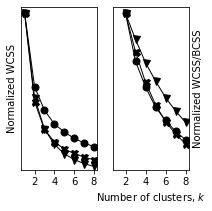

In [26]:
Rh5_inertia_norm = [Rh5_inertia[i]/np.max(Rh5_inertia) for i in range(len(Rh5_inertia))]

Rh18_inertia_norm = [Rh18_inertia[i]/np.max(Rh18_inertia) for i in range(len(Rh18_inertia))]

Rh18_77_inertia_norm = [Rh18_77_inertia[i]/np.max(Rh18_77_inertia) for i in range(len(Rh18_77_inertia))]


Rh5_CH_norm = [Rh5_CH[i]/np.max(Rh5_CH) for i in range(len(Rh5_CH))]
Rh5_CH_norm = [Rh5_CH_norm[i+1] for i in range(len(Rh5_CH)-1)] #remove n=1

Rh18_CH_norm = [Rh18_CH[i]/np.max(Rh18_CH) for i in range(len(Rh18_CH))]
Rh18_CH_norm = [Rh18_CH_norm[i+1] for i in range(len(Rh18_CH)-1)] #remove n=1

Rh18_77_CH_norm = [Rh18_77_CH[i]/np.max(Rh18_77_CH) for i in range(len(Rh18_77_CH))]
Rh18_77_CH_norm = [Rh18_77_CH_norm[i+1] for i in range(len(Rh18_77_CH)-1)] #remove n=1


#Inertia Plots
num_clusters = [1,2,3,4,5,6,7,8]
num_clusters_reduced = [2,3,4,5,6,7,8]

fig,(ax1,ax2) = plt.subplots(1,2, sharey=True)
plt.rcParams['figure.figsize']=(4,3)
plt.rcParams.update({'font.size': 12})

ax1.plot(num_clusters, Rh5_inertia_norm, marker='o', markersize=7,linestyle='-', color='k', lw=1, label='Rh=5.3%, 4 K')
ax1.plot(num_clusters, Rh18_inertia_norm, marker='X', markersize=7,linestyle='-', color='k', lw=1, label='Rh=18%, 4 K')
ax1.plot(num_clusters, Rh18_77_inertia_norm, marker='v', markersize=7,linestyle='-', color='k', lw=1, label='Rh=18%, 77 K')

ax1.set_ylabel("Normalized WCSS")
ax1.set_ylim(0.2,1.03)
ax1.set_yticks([])
ax1.set_xticks([2,4,6,8])

ax2.plot(num_clusters_reduced, Rh5_CH_norm, marker='o', markersize=7,linestyle='-', color='k', lw=1, label='Rh=5.3%, 4 K')
ax2.plot(num_clusters_reduced, Rh18_CH_norm, marker='X', markersize=7,linestyle='-', color='k', lw=1, label='Rh=18%, 4 K')
ax2.plot(num_clusters_reduced, Rh18_77_CH_norm, marker='v', markersize=7,linestyle='-', color='k', lw=1, label='Rh=18%, 77 K')



ax2.set_ylabel("Normalized WCSS/BCSS")
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Number of clusters, $k$")
ax2.set_ylim(0.3,1.03)
ax2.set_xlim(0.7,8.3)
ax2.set_yticks([])
ax2.set_xticks([2,4,6,8])

#plt.savefig('Plots/Fig2_forPresentation.svg')
plt.show()

# Phenomenological Function Fitting <br>

In order to find estimates of the function parameters, we want to calculate the likelihood of our data given some parameter values, then find the maximum the likelihood, in order to find the best estimates of the parameters. Note, here I will assume that our data has Gaussiun errors. Then, our -ln(L) is: <br>

$ln(L) = -\frac{1}{2}\sum_{i=1}^{N}{\left(\frac{y_i-f(x_i | \alpha)}{\sigma_i}\right)^2} - \sum_{i=1}^{N}ln(\sigma_{i}\sqrt{2\pi})$ <br>

Maximizing the above (without the loss function, ie: second term) is equivalent to minimizing the following: <br>

$\chi^2 = \sum_{i=1}^{N}{\left(\frac{y_i-f(x_i | \alpha)}{\sigma_i}\right)^2}$ <br>

In order to minimize this, we must first calculate $\sigma_i$, the standard deviation of each y value. Because we are using the sample mean (not a 'true value' mean) in the calculation of the standard deviations, they must be calculated using the following formula: <br>
$\sigma^2_i = \frac{1}{N-1}\sum_{j}\left(y_j-\bar{y}\right)^2$

The above is a weighted $\chi^2$ squared. <br>

For a goodness of fit parameter, I want to calculate a weighted, reduced $\chi^2$ statistic for each spectrum: <br>

$\chi^2_\nu = \frac{\sum_{i=1}^{N}{\left(\frac{y_i-f(x_i | \alpha)}{\sigma_i}\right)^2}}{\nu}$ <br>

where $i$ is the index over $V$, $\alpha$ are the fitted parameters output by the minimizer, $\nu = N - num_\alpha$ is the degrees of freedom for fitting a single spectrum.

In [112]:
def DOS_B(params, V):
    """
    dI/dV background function

    Parameters
    ----------
    params : array
        array of parameters [c0, c1, c2, c3]
    V : array
        array of bias values
        
    Returns
    -------
    array
        array of y = B(V, c1, c2, c3)
    """
    c1 = params[0]
    c2 = params[1]
    c3 = params[2]
    return c1*V**2 + c2*V + c3


def DOS_M(params, V):
    """
    Mott density of states function

    Parameters
    ----------
    params : array
        array of parameters [c4, M]
    V : array
        array of bias values
        
    Returns
    -------
    array
        array of y = M(V, c4, M)
    """
    c4 = params[0]
    M = params[1]
    E0 = 0.52 #manually adjusted to our data
    w = 0.02 #manually adjusted to our data
    return c4*np.abs(1 / (1+np.exp((V-E0) / w)) - 1 / (1+np.exp((-V+E0-M) / w)))


def DOS_P(params, V):
    """
    pseudogap density of states function

    Parameters
    ----------
    params : array
        array of parameters [c5, P, a]
    V : array
        array of bias values
        
    Returns
    -------
    array
        array of y = P(V, c5, P, a)
    """
    c5 = params[0]
    P = params[1]
    a = params[2]
    
    answer = np.array(c5*np.abs( (np.abs(V) + 1j*a*np.sqrt(np.abs(V))) / np.sqrt( ( np.abs(V) + 1j*a*np.sqrt(np.abs(V)))**2 - P**2)))
    return answer.real #Taking only the real part of the function


In [113]:
def DOS_BM(params, V):
    """
    total density of states for background + Mott

    Parameters
    ----------
    params : array
        array of parameters [c1, c2, c3, c4, M]
    V : array
        array of bias values
        
    Returns
    -------
    array
        array of y = B(V, c1, c2, c3) + M(V, c4, M)
    """
    c1 = params[0]
    c2 = params[1]
    c3 = params[2]
    c4 = params[3]
    M = params[4]
    
    background = DOS_B([c1, c2, c3], V)
    mott = DOS_M([c4, M], V)
    
    sum_bm = [background[i]+mott[i] for i in range(len(V))]
    return sum_bm


def DOS_BP(params, V):
    """
    total density of states for background + pseudogap

    Parameters
    ----------
    params : array
        array of parameters [c1, c2, c3, c5, P, a]
    V : array
        array of bias values
        
    Returns
    -------
    array
        array of y = B(V, c1, c2, c3) + P(V, c5, P, a)
    """
    c1 = params[0]
    c2 = params[1]
    c3 = params[2]
    c5 = params[3]
    P = params[4]
    a = params[5]
    
    background = DOS_B([c1, c2, c3], V)
    pseudogap = DOS_P([c5, P, a], V)
    
    sum_bp = [background[i]+pseudogap[i] for i in range(len(V))]
    return sum_bp


def DOS_BMP(params, V):
    """
    total density of states for background + Mott + pseudogap

    Parameters
    ----------
    params : array
        array of parameters [c1, c2, c3, c4, M, c5, P, a]
    V : array
        array of bias values
        
    Returns
    -------
    array
        array of y = B(V, c1, c2, c3) + M(V, c4, M) + P(V, c5, P, a)
    """
    c1 = params[0]
    c2 = params[1]
    c3 = params[2]
    c4 = params[3]
    M = params[4]
    c5 = params[5]
    P = params[6]
    a = params[7]
    
    background = DOS_B([c1, c2, c3], V)
    mott = DOS_M([c4, M], V)
    pseudogap = DOS_P([c5, P, a], V)
    
    sum_bmp = [background[i]+mott[i]+pseudogap[i] for i in range(len(V))]
    return sum_bmp
    

In [114]:
def chi_squared(params, V, spectrum, DOS):
    """
    calculated an unweighted chi squared value for a fit

    Parameters
    ----------
    params : array
        values for all fitted parameters
    V : array
        array of bias values
    spectrum : array
        point spectrum
    DOS : str
        functions to be fitted. Either 'BM', 'BP', or 'BMP'
        
    Returns
    -------
    float
        unweighted chi-squared value
    """

    y = spectrum
    f = f_of_x(params, V, DOS)
    elements = [(y[i]-f[i])**2 for i in range(len(y))]
    return np.sum(elements)

    
def f_of_x(params, V, DOS):
    """
    calculates analytical spectrum based on fit params

    Parameters
    ----------
    params : array
        values for all fitted parameters
    V : array
        array of bias values
    DOS : str
        terms to include. Either 'BM', 'BP', or 'BMP'
        
    Returns
    -------
    array
        analytical density of states f(V, params)
    """
    
    if DOS=="BM":
        return DOS_BM(params,V)
        
    elif DOS=="BP":
        return DOS_BP(params,V)
        
    elif DOS=="BMP":
        return DOS_BMP(params,V)
    
    else:
        print("Error: The given DOS string is not a valid option")
        return
    
def minimizer(V, spectra, DOS, params0, bounds):
    """
    least-squares regression minimizer

    Parameters
    ----------
    V : array
        array of bias values
    spectra : array
        the spectra to be fit
    DOS : str
        functions to be fitted. Either 'BM', 'BP', or 'BMP'
    params0 : array
        initial guesses for all fitted parameters, as a list
    bounds : array
        boundary values for all fitted parameters, as a list, ie: ((-1, 1), (0, 10))
        
    Returns
    -------
    results : array
        fitted parameter values for each spectrum
    reduced_chi_sq : array
        reduced & weighted chi-squared statistics for each spectrum
    """

    results = [[] for i in range(len(spectra))]
    
    for i in tqdm(range(len(spectra))):
        results[i] = optimize.minimize(lambda params: chi_squared(params,V,spectra[i],DOS), params0, bounds=bounds)
    
    reduced_chi_sq = goodness_of_fit(V, spectra, DOS, results)
    
    return results, reduced_chi_sq

def goodness_of_fit(V, spectra, DOS, results):
    """
    calculates goodness of fit using a weighted and reduced chi-squared statistic

    Parameters
    ----------
    V : array
        array of bias values
    spectra : array
        the spectra to be fit
    DOS : str
        functions to be fitted. Either 'BM', 'BP', or 'BMP'
    results : array
        fitted parameter values for each spectrum
        
    Returns
    -------
    reduced_chi_sq : array
        reduced & weighted chi-squared statistics for each spectrum
    """
    
    weighted_chi_sq = [0 for i in range(len(spectra))]
    reduced_chi_sq = [0 for i in range(len(spectra))]
    dof = len(V) - len(results[0].x) # deg of freedom = N - m
    std_sample = np.std(spectra, axis=0, ddof=1) #std of spectra in a cluster over each point in V
    
    for i in range(len(spectra)): #iterating over the spectra inside a cluster
        
        params = [results[i].x[k] for k in range(len(results[i].x))] #array of fitted parameters for this spectrum
        f = f_of_x(params, V, DOS) #calculated y values for this spectrum given the fitted parameters
        weighted_chi_sq[i] = np.sum([((spectra[i][j]-f[j])/std_sample[j])**2 for j in range(len(V))])
        reduced_chi_sq[i] = weighted_chi_sq[i] / dof
        
    return reduced_chi_sq

In [115]:
#initial guesses of fitting parameters
c1 = 0.5 
c2 = 0.4 
c3 = 0.0
c4 = 0.3 
c5 = 0.4 
M = 0.8 
P = 0.2 
a = 0.2


#bounds for the fitting parameters:
c1_bounds = (0.0, 4.0) #Quadratic background term
c2_bounds = (-0.5, 1.0) #Linear background term
c3_bounds = (-0.4, 0.4) #0th order background term
c4_bounds = (0.02, 1.5) #Mott term prefactor
c5_bounds = (0.1,1.4) #Pseudogap term prefactor
M_bounds = (0.15,1.4) #Size of Mott gap in eV
P_bounds = (0.03, 1.3) #Size of pseudogap in eV
a_bounds = (0.01,1.5)# depth of pseudogap


In [ ]:
#P1 Fitting:
params0 = np.asarray([c1, c2, c3, c5, P, a]) #Initial estimates for fitting variables

#Specific bounds:
bounds = (c1_bounds, c2_bounds, c3_bounds, c5_bounds, P_bounds, a_bounds) #Boundary for params

P1_results, P1_goodness_of_fit = minimizer(V_5, P1_spectra, "BP", params0, bounds) 

In [ ]:
#P1 fitting with BMP instead of BP:
params0 = np.asarray([c1, c2, c3, c4, M, c5, P, a]) #Initial estimates for fitting variables

#Specific bounds:
c4_bounds_special = (0.0,1.5)
bounds = (c1_bounds, c2_bounds, c3_bounds, c4_bounds_special, M_bounds, c5_bounds, P_bounds, a_bounds) #Boundary for params

P1_BMP_results, P1_BMP_goodness_of_fit = minimizer(V_5, P1_spectra, "BMP", params0, bounds)

In [ ]:
#P2 Fitting:
params0 = np.asarray([c1, c2, c3, c5, P, a]) #Initial estimates for fitting variables

#Specific bounds:
bounds = (c1_bounds, c2_bounds, c3_bounds, c5_bounds, P_bounds, a_bounds) #Boundary for params

P2_results, P2_goodness_of_fit = minimizer(V_5, P2_spectra, "BP", params0, bounds) 

In [ ]:
#P2 fitting with BMP instead of BP:
params0 = np.asarray([c1, c2, c3, c4, M, c5, P, a]) #Initial estimates for fitting variables

#Specific bounds:
c4_bounds_special = (0.0,1.5)
bounds = (c1_bounds, c2_bounds, c3_bounds, c4_bounds_special, M_bounds, c5_bounds, P_bounds, a_bounds) #Boundary for params

P2_BMP_results, P2_BMP_goodness_of_fit = minimizer(V_5, P2_spectra, "BMP", params0, bounds)

In [ ]:
#D Fitting:
params0 = np.asarray([c1, c2, c3, c4, M, c5, P, a]) #Initial estimates for fitting variables

bounds = (c1_bounds, c2_bounds, c3_bounds, c4_bounds, M_bounds, c5_bounds, P_bounds, a_bounds) #Boundary for params


D_results, D_goodness_of_fit = minimizer(V_5, D_spectra, "BMP", params0, bounds) 


In [ ]:
#All spectra fitting with BMP:
params0 = np.asarray([c1, c2, c3, c4, M, c5, P, a]) #Initial estimates for fitting variables

#Specific bounds:
c4_bounds_special = (0.0,1.5)
c5_bounds_special = (0.0, 1.4)
bounds = (c1_bounds, c2_bounds, c3_bounds, c4_bounds_special, M_bounds, c5_bounds_special, P_bounds, a_bounds) #Boundary for params

All_results, All_goodness_of_fit = minimizer(V_5, All_spectra, "BMP", params0, bounds)

In [ ]:
#M Fitting with BM:
params0 = np.asarray([c1, c2, c3, c4, M]) #Initial estimates for fitting variables

#Special bounds:
bounds = (c1_bounds, c2_bounds, c3_bounds, c4_bounds, M_bounds) #Boundary for params


M_full_results, M_full_goodness_of_fit = minimizer(V_5, M_spectra, "BM", params0, bounds) 

In [ ]:
#M fitting, with BMP instead of BM:
params0 = np.asarray([c1, c2, c3, c4, M, c5, P, a]) #Initial estimates for fitting variables

#Special bounds:
c5_bounds_special = (0.0, 1.4)
bounds = (c1_bounds, c2_bounds, c3_bounds, c4_bounds, M_bounds, c5_bounds_special, P_bounds, a_bounds) #Boundary for params

M_BMP_full_results, M_BMP_full_goodness_of_fit = minimizer(V_5, M_spectra, "BMP", params0, bounds)

In [131]:
def results_saver(results, goodness_of_fit, DOS, filename):
    """
    saves fit results as a csv

    Parameters
    ----------
    results : array
        fitted parameter values for each spectrum
    goodness_of_fit : array
        reduced & weighted chi-squared statistics for each spectrum
    DOS : str
        functions to be fitted. Either 'BM', 'BP', or 'BMP'
    filename : str
        file name to save the results under. Not including extension
    """
    
    if DOS=="BP":
        c1_values = [results[i].x[0] for i in range(len(results))]
        c2_values = [results[i].x[1] for i in range(len(results))]
        c3_values = [results[i].x[2] for i in range(len(results))]
        c5_values = [results[i].x[3] for i in range(len(results))]
        P_values = [results[i].x[4] for i in range(len(results))]
        a_values = [results[i].x[5] for i in range(len(results))]
        results_dictionary ={'c1':c1_values, 'c2':c2_values, 'c3':c3_values, 'c5':c5_values, 'P':P_values,
                             'a':a_values, 'chi_stat':goodness_of_fit}
        
    if DOS=="BM":
        c1_values = [results[i].x[0] for i in range(len(results))]
        c2_values = [results[i].x[1] for i in range(len(results))]
        c3_values = [results[i].x[2] for i in range(len(results))]
        c4_values = [results[i].x[3] for i in range(len(results))]
        M_values = [results[i].x[4] for i in range(len(results))]

        results_dictionary = {'c1':c1_values, 'c2':c2_values, 'c3':c3_values, 'c4':c4_values,
                   'M':M_values, 'chi_stat':goodness_of_fit}
        
    if DOS=="BMP":
        c1_values = [results[i].x[0] for i in range(len(results))]
        c2_values = [results[i].x[1] for i in range(len(results))]
        c3_values = [results[i].x[2] for i in range(len(results))]
        c4_values = [results[i].x[3] for i in range(len(results))]
        M_values = [results[i].x[4] for i in range(len(results))]
        c5_values = [results[i].x[5] for i in range(len(results))]
        P_values = [results[i].x[6] for i in range(len(results))]
        a_values = [results[i].x[7] for i in range(len(results))]
        results_dictionary = {'c1':c1_values, 'c2':c2_values, 'c3':c3_values, 'c4':c4_values, 'M':M_values,
                              'c5':c5_values, 'P':P_values, 'a':a_values, 'chi_stat':goodness_of_fit}
    
    dataframe = pd.DataFrame(results_dictionary)
    dataframe.to_csv(filename + ".csv", index=False)
    return

In [ ]:
#Save the results
results_saver(P1_results, P1_goodness_of_fit, "BP", "P1_fitting_results")
results_saver(P2_results, P2_goodness_of_fit, "BP", "P2_fitting_results")
results_saver(P1_BMP_results, P1_BMP_goodness_of_fit, "BMP", "P1_BMP_fitting_results")
results_saver(P2_BMP_results, P2_BMP_goodness_of_fit, "BMP", "P2_BMP_fitting_results")
results_saver(D_results, D_goodness_of_fit, "BMP", "D_fitting_results")
results_saver(All_results, All_goodness_of_fit, "BMP", "All_fitting_results")
results_saver(M_full_results, M_full_goodness_of_fit, "BM", "M_full_fitting_results")
results_saver(M_BMP_full_results, M_BMP_full_goodness_of_fit, "BMP", "M_BMP_full_fitting_results")

In [28]:
#Load the fitted parameters :
P1_dataframe = pd.read_csv("P1_fitting_results.csv")
P2_dataframe = pd.read_csv("P2_fitting_results.csv")
D_dataframe = pd.read_csv("D_fitting_results.csv")
P1_BMP_dataframe = pd.read_csv("P1_BMP_fitting_results.csv")
P2_BMP_dataframe = pd.read_csv("P2_BMP_fitting_results.csv")
All_dataframe = pd.read_csv("All_fitting_results.csv")
M_full_dataframe = pd.read_csv("M_full_fitting_results.csv")
M_BMP_full_dataframe = pd.read_csv("M_BMP_full_fitting_results.csv")


In [29]:
#Define dataframe dictionary
dataframe_dict = {'P1_dataframe':'P1', 'P2_dataframe':'P2', 'M_dataframe':'M', 
                  'D_dataframe':'D', 'M_BMP_dataframe':'M', 'P1_BMP_dataframe':'P1',
                 'P2_BMP_dataframe':'P2', 'All_dataframe':'all', 'M_full_dataframe':'M',
                 'M_BMP_full_dataframe':'M'}

# Analysis of fitting results

In [30]:
def chi_sq_med(dataframe):
    """
    Calculate median of the chi-squared distributions

    Parameters
    ----------
    dataframe : pandas dataframe
        results loaded as a dataframe
        
    Returns
    -------
    float
        median value of the chi-squared distribution
    """
    median = dataframe.median()
    return median['chi_stat']

print("P1 without a Mott term: ",chi_sq_med(P1_dataframe))
print("P2 without a Mott term: ",chi_sq_med(P2_dataframe))
print("P1 with a Mott term: ",chi_sq_med(P1_BMP_dataframe))
print("P2 with a Mott term: ",chi_sq_med(P2_BMP_dataframe))
print("D: ",chi_sq_med(D_dataframe))
print("all spectra: ",chi_sq_med(All_dataframe))
print("M without P term: ",chi_sq_med(M_full_dataframe))
print("M with P term: ",chi_sq_med(M_BMP_full_dataframe))


P1 without a Mott term:  0.9833574862433538
P2 without a Mott term:  0.6633728160872374
P1 with a Mott term:  1.0006947347257382
P2 with a Mott term:  0.5651814172574159
D:  0.6701085539055378
all spectra:  0.4161632620595413
M without P term:  2.4787482361043733
M with P term:  0.3243051762350311


In [46]:
import seaborn as sns

def parameter_hist_sns(dataframes, dataframe_names, parameter, xlims, fig_name):
    """
    Create a histogram plot to visualize parameter distributions

    Parameters
    ----------
    dataframes : array
        array of dataframes of results
    dataframe_names : array
        array of strings of the dataframe names
    parameter : str
        the parameter to plot
    xlims : array
        array of x limit values for the plot
    fig_name : str
        name of the figure for saving
    """
    
    fig, ax = plt.subplots(figsize=(3,3))
    meaningful_values=[]
    
    for index, dataframe in enumerate(dataframes):
        colour = colour_dict[dataframe_dict[dataframe_names[index]]]

        if parameter == 'M':
            meaningful_values=[]
            for i, value in enumerate(dataframe['c4']):
                if value != 0.0:
                    meaningful_values.append(dataframe[parameter][i])
            sns.histplot(x=meaningful_values, bins=50, alpha=0.5,color=colour, element='step', lw=0, ax=ax)
 
        elif parameter == 'P' or parameter == 'a':
            meaningful_values=[]
            for i, value in enumerate(dataframe['c5']):
                if value != 0.0:
                    meaningful_values.append(dataframe[parameter][i])  
            sns.histplot(x=meaningful_values, bins=50, alpha=0.5,color=colour, element='step', lw=0, ax=ax)

        else:
            sns.histplot(x=meaningful_values, bins=50, alpha=0.5,color=colour, element='step', lw=0, ax=ax)
    
    y_ticks = ax.get_yticks()
    y_ticks = [str(int(y_ticks[i]/1000)) for i in range(len(y_ticks))]
    ax.set_yticklabels(y_ticks)
    
    ax.set_ylabel("Frequency ($\\times 10^3$)")
    ax.set_xlabel("$\Delta$ "+parameter)
    ax.set_xlim(xlims)
    plt.savefig(fig_name, dpi='figure')
    plt.show()
    
    return

## Figure 4.f)

/var/folders/w5/7bdvx1vj2jn06jd3450tmw100000gn/T/ipykernel_59220/3497080749.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


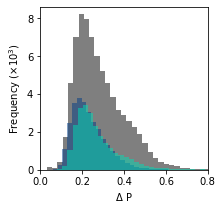

In [47]:
parameter_hist_sns([All_dataframe, P1_BMP_dataframe, P2_BMP_dataframe],
                   ['All_dataframe','P1_BMP_dataframe','P2_BMP_dataframe'],
                    'P', (0.0,0.8),"Plots/Fig4f.svg")

## Figure 4.e)

/var/folders/w5/7bdvx1vj2jn06jd3450tmw100000gn/T/ipykernel_59220/3497080749.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


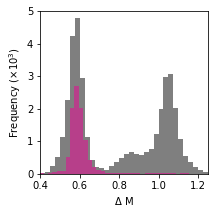

In [48]:
parameter_hist_sns([All_dataframe, M_BMP_full_dataframe],
                   ['All_dataframe','M_BMP_full_dataframe'],
                    'M', (0.4,1.25),"Plots/Fig4e.svg")

In [136]:
def parameter_over_grid_heat_map(dataframe, cluster, parameter, labels, cmap, fileName):
    """
    Plot heat map of a fitting parameter for a given cluster dataframe over the grid.

    Parameters
    ----------
    dataframe : dataframe
        pandas dataframe of the fitted parameters
    cluster : int
        the cluster of interest from dataset dictionary, or 10 for all spectra
    parameter : str
        the parameter to plot
    labels : array
        cluster labels from k-means results, in shape (x,y)
    cmap : colour map
        colour map for plot
    fileName : str
        name of the figure for saving, including extension
    """
    
    #turn labels from 2D into 1D:
    labels_1D = flatten(labels)
    
    heat_map = [np.nan for i in range(len(labels_1D))]
    cluster_counter = 0
    
    if cluster == 10:
        for index, label in enumerate(labels_1D):
            heat_map[index] = dataframe.get(parameter)[index]
    else:
        for index, label in enumerate(labels_1D):
            if label==cluster: 
                #print(dataframe[parameter][cluster_counter])
                heat_map[index] = dataframe.get(parameter)[cluster_counter]
                cluster_counter+=1
            
    #turn heat_map from 1D into 2D:
    heat_map_2D = np.reshape(heat_map, np.shape(labels) )
    
    plt.rcParams['figure.figsize']=(5,4)
    fig,(ax2) = plt.subplots()
    im = ax2.imshow(heat_map_2D, cmap = cmap)
    ax2.set_xticks([]); ax2.set_yticks([])
    fig.colorbar(im, aspect=10, ticks=[])
    plt.savefig(fileName)
    plt.show()
    
    return

## Figure 3.a)

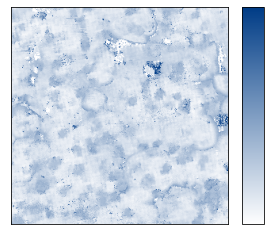

In [318]:
#Pseudogap map:
cmap = colors.LinearSegmentedColormap.from_list("Pseudogap_cmap", ["white", colour_dict['P1']])

parameter_over_grid_heat_map(All_dataframe, 10, 'P', labels_5, cmap,'Plots/Fig3a_Jun12.svg')


## Figure 3.b)

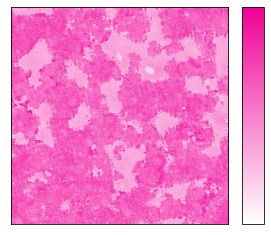

In [319]:
#Mott gap map:
cmap = colors.LinearSegmentedColormap.from_list("Mott_cmap", ["white", colour_dict['M']])

parameter_over_grid_heat_map(All_dataframe, 10, 'M', labels_5, cmap, 'Plots/Fig3b_Jun12.svg')

## Figure 3.d)

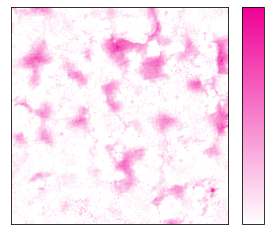

In [321]:
#Mott gap map:
cmap = colors.LinearSegmentedColormap.from_list("Mott_cmap", ["white", colour_dict['M']])

parameter_over_grid_heat_map(All_dataframe, 10, 'c4', labels_5, cmap, 'Plots/Fig3d_Jun12.svg')

## Figure 3.c)

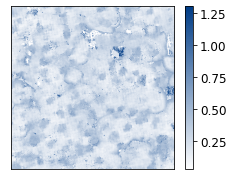

In [250]:
#Pseudogap map:
cmap = colors.LinearSegmentedColormap.from_list("Pseudogap_cmap", ["white", colour_dict['P1']])

parameter_over_grid_heat_map(All_dataframe, 10, 'c5', labels_5, cmap, 'Plots/Fig3c_Jun12.svg')

In [154]:
#Fitting to sample spectra
energy = bias(Rh5_4K_dict['startV'], Rh5_4K_dict['endV'], data_5)
#For ease of analysis, I will multiply the dI/dV data by 10^11 

sample_spectrum = [np.array(sample_spectra['M'])*1e11, np.array(sample_spectra['D'])*1e11, 
                   np.array(sample_spectra['P2'])*1e11, np.array(sample_spectra['P1'])*1e11]


In [157]:
#With BMP:
params0 = np.asarray([c1, c2, c3, c4, M, c5, P, a]) #Initial estimates for fitting variables
bounds = (c1_bounds, c2_bounds, c3_bounds, c4_bounds, M_bounds, c5_bounds, P_bounds, a_bounds) #Boundary for params
sample_BMP_results, sample_BMP_goodness_of_fit = minimizer(energy, sample_spectrum, "BMP", params0, bounds)

#With BM:
params0 = np.asarray([c1, c2, c3, c4, M]) #Initial estimates for fitting variables
bounds = (c1_bounds, c2_bounds, c3_bounds, c4_bounds, M_bounds) #Boundary for params
sample_BM_results, sample_BM_goodness_of_fit = minimizer(energy, sample_spectrum, "BM", params0, bounds)

#With BP:
params0 = np.asarray([c1, c2, c3, c5, P, a]) #Initial estimates for fitting variables
bounds = (c1_bounds, c2_bounds, c3_bounds, c5_bounds, P_bounds, a_bounds) #Boundary for params
sample_BP_results, sample_BP_goodness_of_fit = minimizer(energy, sample_spectrum, "BP", params0, bounds)

#save them all
results_saver(sample_BMP_results, sample_BMP_goodness_of_fit, "BMP", "sample_BMP_fitting_results")
results_saver(sample_BM_results, sample_BM_goodness_of_fit, "BM", "sample_BM_fitting_results")
results_saver(sample_BP_results, sample_BP_goodness_of_fit, "BP", "sample_BP_fitting_results")

100%|███████████████████████████████████████████████| 4/4 [00:00<00:00, 51.83it/s]


In [158]:
#Load the fitted parameters:
sample_BMP_dataframe = pd.read_csv("sample_BMP_fitting_results.csv")
sample_BM_dataframe = pd.read_csv("sample_BM_fitting_results.csv")
sample_BP_dataframe = pd.read_csv("sample_BP_fitting_results.csv")

In [159]:
def lines_from_fit_parameters_for_samples(cluster, dataframe, V, DOS):
    """
    generate analytical lines based on fitted parameters

    Parameters
    ----------
    cluster : int
        the cluster of interest from dataset dictionary, or 10 for all spectra
    dataframe : dataframe
        pandas dataframe of the fitted parameters
    V : array
        bias voltage array
    DOS : str
        Terms of the fitting function, ie: 'BM', 'BP', 'BMP'
            
    Returns
    -------
    line : array
        calculated values of the line based on the fitted parameters
    """
    
    #first, get out the necessary parameters from the dataframe
    params = [dataframe['c1'][cluster], dataframe['c2'][cluster], dataframe['c3'][cluster]]

    if DOS=="BM":
        params.append(dataframe['c4'][cluster])
        params.append(dataframe['M'][cluster])
    if DOS=="BP":
        params.append(dataframe['c5'][cluster])
        params.append(dataframe['P'][cluster])
        params.append(dataframe['a'][cluster])
    if DOS=="BMP":
        params.append(dataframe['c4'][cluster])
        params.append(dataframe['M'][cluster])
        params.append(dataframe['c5'][cluster])
        params.append(dataframe['P'][cluster])
        params.append(dataframe['a'][cluster])
    
    #second, generate the fit line
    line = f_of_x(params, V, DOS)
    
    return line

M_BMP_line = lines_from_fit_parameters_for_samples(0,sample_BMP_dataframe, energy, "BMP")
M_BM_line = lines_from_fit_parameters_for_samples(0,sample_BM_dataframe, energy, "BM")

P1_BMP_line = lines_from_fit_parameters_for_samples(3,sample_BMP_dataframe, energy, "BMP")
P1_BP_line = lines_from_fit_parameters_for_samples(3,sample_BP_dataframe, energy, "BP")

P2_BMP_line = lines_from_fit_parameters_for_samples(2,sample_BMP_dataframe, energy, "BMP")
P2_BP_line = lines_from_fit_parameters_for_samples(2,sample_BP_dataframe, energy, "BP")

D_BMP_line = lines_from_fit_parameters_for_samples(1,sample_BMP_dataframe, energy, "BMP")

## Figure 4.a)

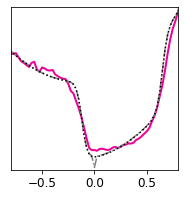

In [194]:
#Plot Mott sample spectrum and various fits on it
energy = bias(Rh18_4K_dict['startV'], Rh18_4K_dict['endV'], data_5)

plt.rcParams.update({'font.size': 12})
fig,(ax1) = plt.subplots(figsize=(3,3))

ax1.plot(energy, sample_spectrum[0], marker='',linestyle='solid', lw=2, color=colour_dict['M'], label='Sample spectrum')
ax1.plot(energy, M_BMP_line, marker='',linestyle='dashdot', lw=1.5, label='BMP fit', color='grey')
ax1.plot(energy, M_BM_line, marker='',linestyle='dotted', lw=1.5, label='BM fit', color='k')

ax1.set_xlim([-0.8,0.8])
ax1.set_ylim([-0.18,1.3])
ax1.set_yticks([])

#plt.savefig('Plots/Fig4a.svg')
plt.show()

## Figure 4.a)-inset

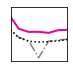

In [193]:
#Plot Mott sample spectrum and various fits on it
energy = bias(Rh18_4K_dict['startV'], Rh18_4K_dict['endV'], data_5)

plt.rcParams.update({'font.size': 12})
fig,(ax1) = plt.subplots(figsize=(1,1))

ax1.plot(energy, sample_spectrum[0], marker='',linestyle='solid', lw=2, color=colour_dict['M'], label='Sample spectrum')
ax1.plot(energy, M_BMP_line, marker='',linestyle='dashdot', lw=1.5, label='BMP fit', color='grey')
ax1.plot(energy, M_BM_line, marker='',linestyle='dotted', lw=1.5, label='BM fit', color='k')

ax1.set_xlim([-0.07,0.07])
ax1.set_ylim([-0.18,0.15])
ax1.set_xticks([]); ax1.set_yticks([])

#plt.savefig('Plots/Fig4a_inset.svg')
plt.show()

## Figure 4.b)

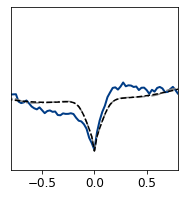

In [195]:
#Plot P1 sample spectrum and various fits on it
plt.rcParams.update({'font.size': 12})
fig,(ax1) = plt.subplots(figsize=(3,3))

ax1.plot(energy, sample_spectrum[3], marker='',linestyle='solid', lw=2, color=colour_dict['P1'], label='Sample spectrum')
ax1.plot(energy, P1_BMP_line, marker='',linestyle='dashdot', lw=1.5, label='BMP fit', color='grey')
ax1.plot(energy, P1_BP_line, marker='',linestyle='dashed', lw=1.5,label='BP fit', color='k')

ax1.set_xlim([-0.8,0.8])
ax1.set_ylim([-0.18,1.3])
ax1.set_yticks([])

#plt.savefig('Plots/Fig4b.svg')
plt.show()

## Figure 4.b)-inset

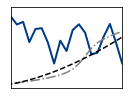

In [196]:
#Plot P1 sample spectrum and various fits on it
plt.rcParams.update({'font.size': 12})
fig,(ax1) = plt.subplots(figsize=(2,1.5))

ax1.plot(energy, sample_spectrum[3], marker='',linestyle='solid', lw=2, color=colour_dict['P1'], label='Sample spectrum')
ax1.plot(energy, P1_BMP_line, marker='',linestyle='dashdot', lw=1.5, label='BMP fit', color='grey')
ax1.plot(energy, P1_BP_line, marker='',linestyle='dashed', lw=1.5,label='BP fit', color='k')

ax1.set_xlim([0.35,0.8])
ax1.set_ylim([0.47,0.6])
ax1.set_xticks([]); ax1.set_yticks([])

#plt.savefig('Plots/Fig4b_inset.svg')
plt.show()

## Figure 4.c)

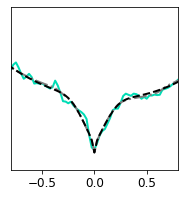

In [197]:
#Plot P2 sample spectrum and various fits on it
plt.rcParams.update({'font.size': 12})
fig,(ax1) = plt.subplots(figsize=(3,3))

ax1.plot(energy, sample_spectrum[2], marker='',linestyle='solid', lw=2, color=colour_dict['P2'], label='Sample spectrum')
ax1.plot(energy, P2_BMP_line, marker='',linestyle='dashdot', lw=2, label='BMP fit', color='grey')
ax1.plot(energy, P2_BP_line, marker='',linestyle='dashed', lw=2, label='BP fit', color='k')

ax1.set_xlim([-0.8,0.8])
ax1.set_ylim([-0.18,1.3])
ax1.set_yticks([])

#plt.savefig('Plots/Fig4c.svg')
plt.show()